In [16]:
import sys
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
from tqdm import tqdm
import pandas as pd

from explainability_utils import *

# Add the 'training' directory to sys.path
sys.path.append(os.path.abspath("../training"))
from training_utils import CNN2D, ExplainerDataset

In [17]:
# Path to the data
base_path = "..\preprocessed_dset"
data_path = os.path.join(base_path, "spectrograms")
meta_path = os.path.join(base_path, "metadata.csv")

shap_data_path = 'samples'

output_path = "shap_tensors"
os.makedirs(output_path, exist_ok=True)
MAX_EVALS = 5000


f_t_range_64_path = os.path.join(data_path, "f_t_range.npy")
tf = np.load(f_t_range_64_path)

ft = [tf[:2], tf[2:]]

# Path to the best model found in the training notebooks
best_model_path = r"..\training\model_checkpoints\best_model_fold_2.ckpt"
best_model_c_path = r"..\training\model_checkpoints\best_model_c_fold_2.ckpt"

sample_dim = (33, 96)

# Setting for the datasets
mean, std = spectra_stats(data_path, meta_path)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

(..\preprocessed_dset\spectrograms) Mean: [0.68137387 0.66712049 0.64939852], Std: [0.13272135 0.1345285  0.13304515] (calculated and saved)
Using device: cuda


### Compute SHAP Tensor for each explainability set sample

In [18]:
model = CNN2D.load_from_checkpoint(best_model_path, input_dim=sample_dim, num_classes=2)
model.eval()
model.to(device)
print("Model loaded")

Model loaded


#### Foreshocks

In [19]:
dset_pre = ExplainerDataset(data_path = os.path.join(shap_data_path, 'foreshocks'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_pre = DataLoader(dset_pre, batch_size=1, shuffle=False)

In [ ]:
output_dir = os.path.join(output_path, "foreshocks")
os.makedirs(output_dir, exist_ok=True)
for sample in tqdm(dloader_pre, total = 300):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = output_dir)

In [9]:
# Compute mean SHAP Tensor (P-fixed)

output_dir = os.path.join(output_path, "foreshocks")
p_mean_pre = np.zeros((*sample_dim, 3)) # shape (33, 96, 3)
tot = 300

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        shap = np.load(file_path) # shape (1, 33, 96, 3)
        shap = shap.squeeze(axis=0) # shape (33, 96, 3)
        p_mean_pre += shap/tot

np.save(os.path.join(output_path, "avg_p_pre.npy"), p_mean_pre)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_p_pre.npy')} \nShape: {p_mean_pre.shape}")

100%|██████████| 300/300 [00:00<00:00, 1072.83it/s]

Tensor saved at: shap_tensors\avg_p_pre.npy 
Shape: (33, 96, 3)


In [10]:
# Compute mean SHAP Tensor (S-fixed)

output_dir = os.path.join(output_path, "foreshocks")
df = pd.read_csv(meta_path)
tot = 300
pixel_per_sec = sample_dim[1]/13
duration = int(8*pixel_per_sec)
s_mean_pre = np.zeros((sample_dim[0], duration, 3)) # shape (33, 59, 3)

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        trace_name = filename.removesuffix(".npy")
        shap = np.load(file_path).squeeze(axis=0) # shape (33, 96, 3)
        p_s_diff_sec = df[df["trace_name"]==trace_name]["p_s_diff_sec"].values[0]

        s_arrival = 5 + p_s_diff_sec
        start = s_arrival - 4
        start_pixel = int(start * pixel_per_sec)
        shap = shap[:,start_pixel:start_pixel+duration,:]

        s_mean_pre += shap/tot

np.save(os.path.join(output_path, "avg_s_pre.npy"), s_mean_pre)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_s_pre.npy')} \nShape: {s_mean_pre.shape}")

100%|██████████| 300/300 [00:00<00:00, 341.36it/s]

Tensor saved at: shap_tensors\avg_s_pre.npy 
Shape: (33, 59, 3)


#### Aftershocks

In [20]:
dset_post = ExplainerDataset(data_path = os.path.join(shap_data_path, 'aftershocks'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_post = DataLoader(dset_post, batch_size=1, shuffle=False)

In [ ]:
output_dir = os.path.join(output_path, "aftershocks")
os.makedirs(output_dir, exist_ok=True)
for sample in tqdm(dloader_post, total = 300):
    compute_shap_tensor(model = model,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = output_dir)

In [22]:
# Compute mean SHAP Tensor (P-fixed)

output_dir = os.path.join(output_path, "aftershocks")
p_mean_post = np.zeros((*sample_dim, 3)) # shape (33, 96, 3)
tot = 300

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        shap = np.load(file_path) # shape (1, 33, 96, 3)
        shap = shap.squeeze(axis=0) # shape (33, 96, 3)
        p_mean_post += shap/tot

np.save(os.path.join(output_path, "avg_p_post.npy"), p_mean_post)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_p_post.npy')} \nShape: {p_mean_post.shape}")

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 844.71it/s]

Tensor saved at: shap_tensors\avg_p_post.npy 
Shape: (33, 96, 3)


In [23]:
# Compute mean SHAP Tensor (S-fixed)

output_dir = os.path.join(output_path, "aftershocks")
df = pd.read_csv(meta_path)
tot = 300
pixel_per_sec = sample_dim[1]/13
duration = int(8*pixel_per_sec)
s_mean_post = np.zeros((sample_dim[0], duration, 3)) # shape (33, 59, 3)

for filename in tqdm(os.listdir(output_dir), total = tot):
    if filename.endswith(".npy"):
        file_path = os.path.join(output_dir, filename)
        trace_name = filename.removesuffix(".npy")
        shap = np.load(file_path).squeeze(axis=0) # shape (33, 96, 3)
        p_s_diff_sec = df[df["trace_name"]==trace_name]["p_s_diff_sec"].values[0]

        s_arrival = 5 + p_s_diff_sec
        start = s_arrival - 4
        start_pixel = int(start * pixel_per_sec)
        shap = shap[:,start_pixel:start_pixel+duration,:]

        s_mean_post += shap/tot

np.save(os.path.join(output_path, "avg_s_post.npy"), s_mean_post)
print(f"Tensor saved at: {os.path.join(output_path, 'avg_s_post.npy')} \nShape: {s_mean_post.shape}")

100%|██████████| 300/300 [00:00<00:00, 355.94it/s]

Tensor saved at: shap_tensors\avg_s_post.npy 
Shape: (33, 59, 3)


#### Colocated

In [ ]:
model_c = CNN2D.load_from_checkpoint(best_model_c_path, input_dim=sample_dim, num_classes=2)
model_c.eval()
model_c.to(device)
print("Model loaded")

dset_c = ExplainerDataset(data_path = os.path.join(shap_data_path, 'colocated'), 
                            dataframe_path = meta_path, 
                            transform=transform)

dloader_c = DataLoader(dset_c, batch_size=1, shuffle=False)

output_dir = os.path.join(output_path, "colocated")
os.makedirs(output_dir, exist_ok=True)
for sample in tqdm(dloader_c, total = 130):
    compute_shap_tensor(model = model_c,
                        sample = sample,
                        dim = sample_dim,
                        device = device,
                        max_evals = MAX_EVALS,
                        save_dir = output_dir)

### Plots

#### P-fixed

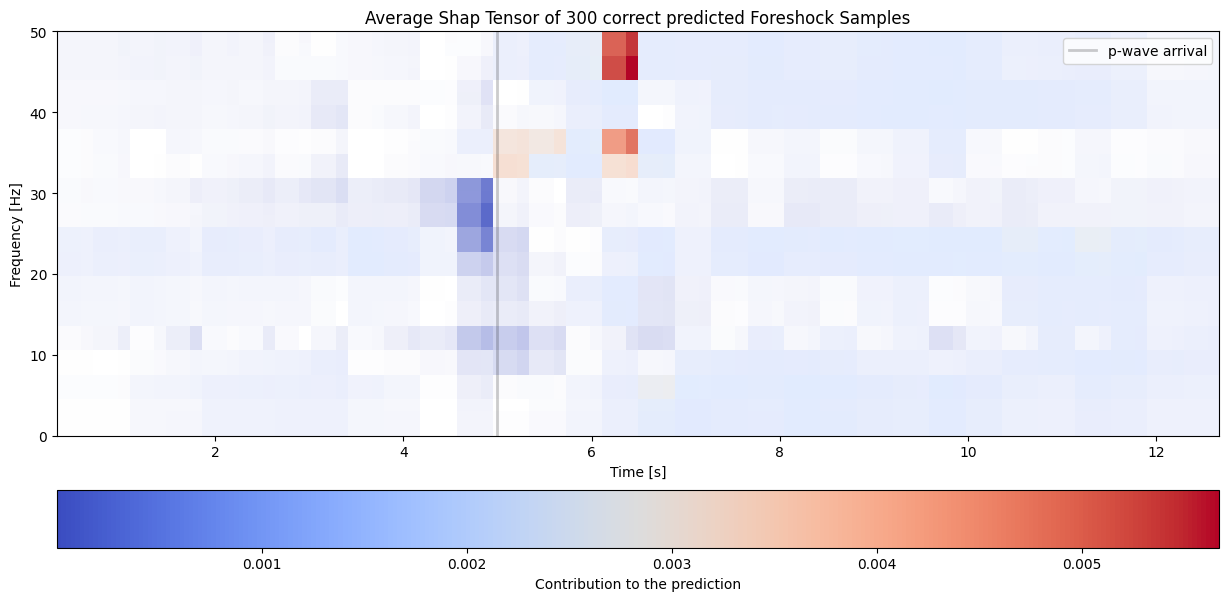

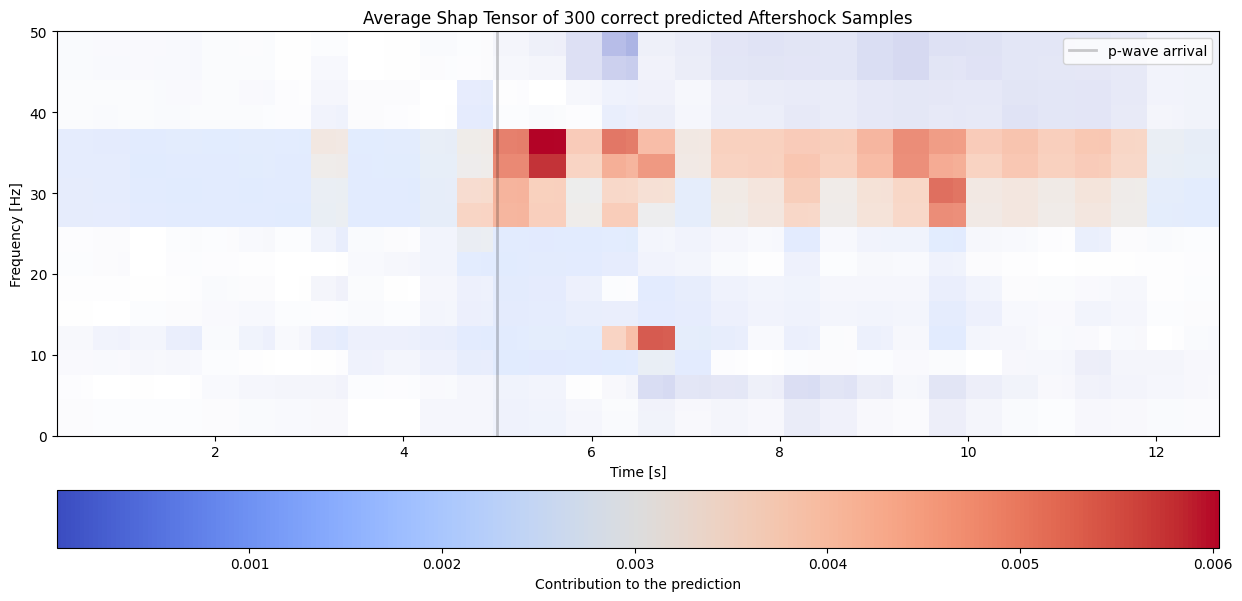

In [24]:
# Plot SHAP Tensor (P-fixed)
p_mean_pre = np.load(os.path.join(output_path, "avg_p_pre.npy"))
plot_mean_shap_p(p_mean_pre.mean(axis=-1), ft, title = "Average Shap Tensor of 300 correct predicted Foreshock Samples")

p_mean_post = np.load(os.path.join(output_path, "avg_p_post.npy"))
plot_mean_shap_p(p_mean_post.mean(axis=-1), ft, title = "Average Shap Tensor of 300 correct predicted Aftershock Samples")

#### S-fixed

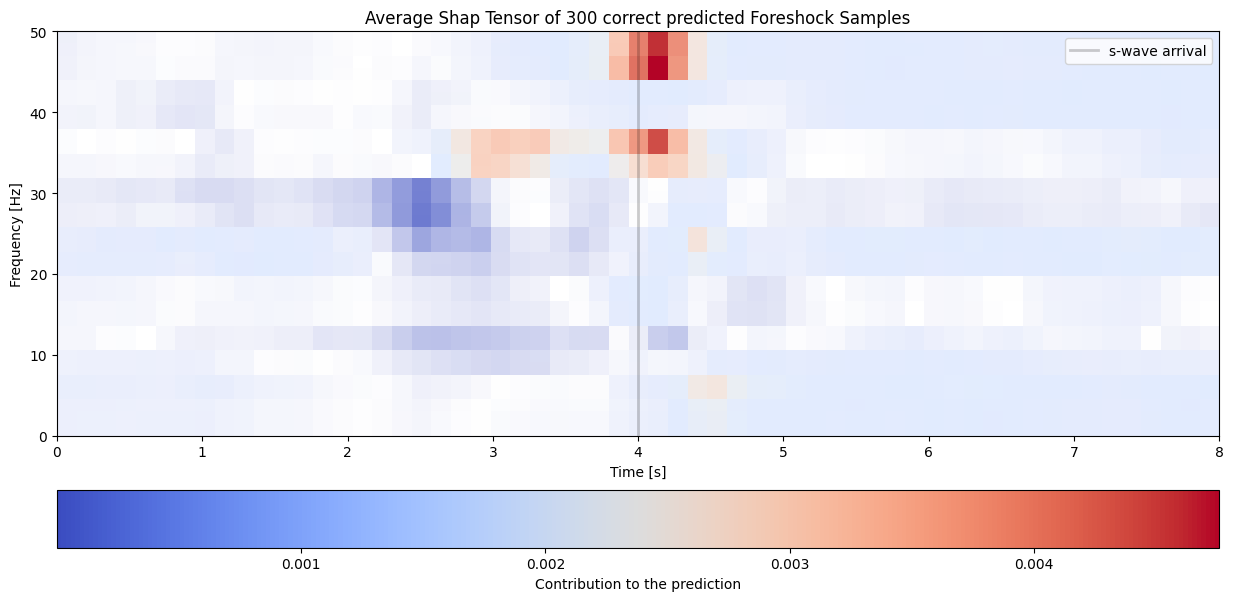

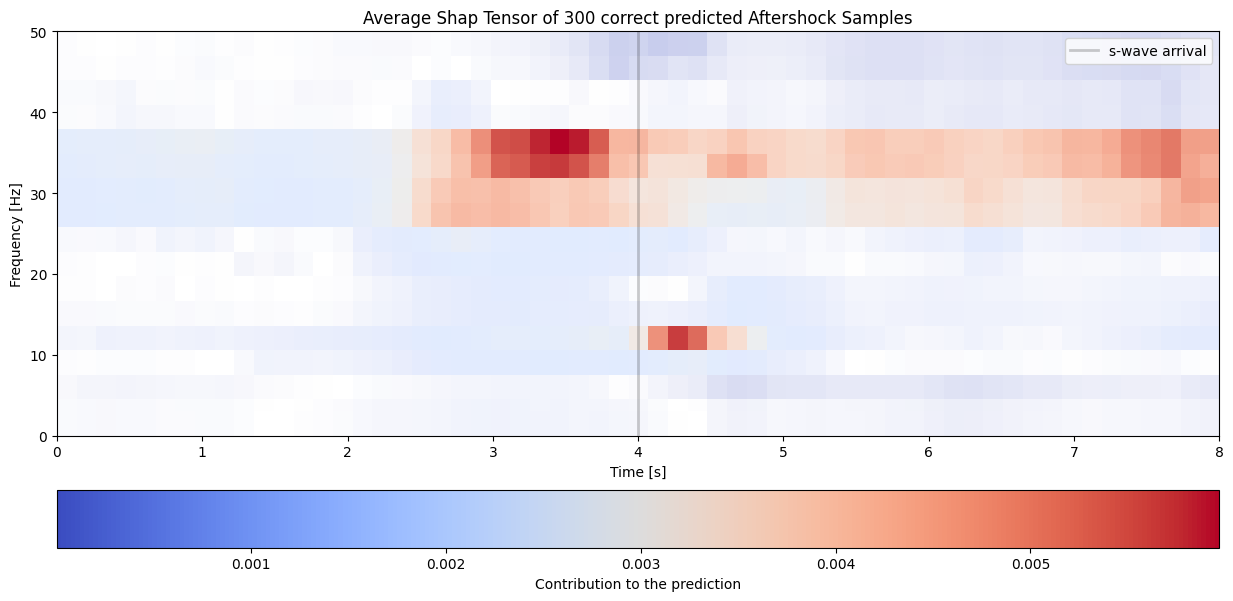

In [25]:
# Plot SHAP Tensor (P-fixed)
s_mean_pre = np.load(os.path.join(output_path, "avg_s_pre.npy"))
plot_mean_shap_s(s_mean_pre.mean(axis=-1), ft, title = "Average Shap Tensor of 300 correct predicted Foreshock Samples")

s_mean_post = np.load(os.path.join(output_path, "avg_s_post.npy"))
plot_mean_shap_s(s_mean_post.mean(axis=-1), ft, title = "Average Shap Tensor of 300 correct predicted Aftershock Samples")